In [1]:
import src
import pyaldata
import pandas as pd
import seaborn as sns

sns.set_context('talk')

%load_ext autoreload
%autoreload 2

In [2]:
td = src.data.load_clean_data('/mnt/g/raeed/project-data/smile/cst-gainlag/library/Prez_20220720_RTTCSTCO_TD.mat',verbose=True,keep_unsorted=True)
td = (
    td.loc[(td['task']=='RTT') | (td['task']=='CST'),:]
    .pipe(src.data.trim_nans)
    .pipe(src.data.fill_kinematic_signals)
)

Removed 76 trials that monkey aborted
2 trials with high firing rates removed. Dropping trials with IDs:
[295 337]
Removed 0 neurons from M1_spikes.
Removed 0 neurons from MC_spikes.
Removed 0 neurons from PMd_spikes.


In [3]:
def extract_td_epochs(td):
    '''
    Prepare data for hold-time PCA and LDA, as well as data for smooth hold/move M1 activity
    
    Arguments:
        args (Namespace): Namespace of command-line arguments
        
    Returns:
        td_binned (DataFrame): PyalData formatted structure of neural/behavioral data
        td_smooth (DataFrame): PyalData formatted structure of neural/behavioral data
    '''
    binned_epoch_dict = {
        'ambig_hold': src.util.generate_realtime_epoch_fun(
            'idx_pretaskHoldTime',
            rel_start_time=-0.3,
        ),
        'hold': src.util.generate_realtime_epoch_fun(
            'idx_goCueTime',
            rel_start_time=-0.3,
        ),
        'move': src.util.generate_realtime_epoch_fun(
            'idx_goCueTime',
            rel_start_time=0,
            rel_end_time=0.3,
        ),
    }

    td_binned = (
        td.copy()
        .pipe(src.util.split_trials_by_epoch,binned_epoch_dict)
        .pipe(src.data.rebin_data,new_bin_size=0.3)
        .pipe(pyaldata.add_firing_rates,method='bin')
    )

    spike_fields = [name for name in td.columns.values if name.endswith("_spikes")]
    for field in spike_fields:
        assert td_binned[field].values[0].ndim==1, "Binning didn't work"

    smooth_epoch_dict = {
        'hold_move': src.util.generate_realtime_epoch_fun(
            'idx_goCueTime',
            rel_start_time=-0.8,
            rel_end_time=0.5,
        ),
        'hold_move_ref_cue': src.util.generate_realtime_epoch_fun(
            'idx_pretaskHoldTime',
            rel_start_time=-0.3,
            rel_end_time=1.0,
        ),
        'full': lambda trial : slice(0,trial['hand_pos'].shape[0]),
    }
    td_smooth = (
        td.copy()
        .pipe(pyaldata.add_firing_rates,method='smooth',std=0.05,backend='convolve')
        .pipe(src.util.split_trials_by_epoch,smooth_epoch_dict)
        .pipe(src.data.rebin_data,new_bin_size=0.05)
    )

    td_epochs = pd.concat([td_binned,td_smooth]).reset_index()

    return td_epochs

In [4]:
td_epoch = extract_td_epochs(td.rename(columns={'M1_rates':'M1_orig_rates','MC_rates':'M1_rates'}))

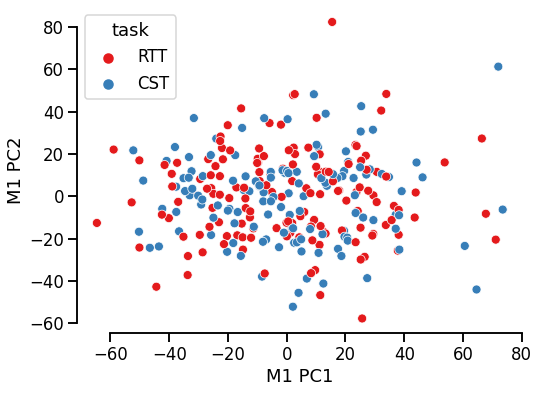

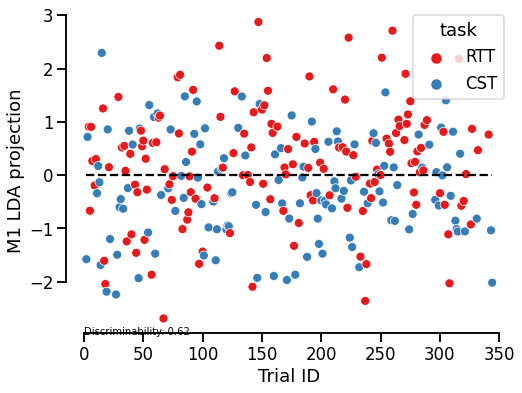

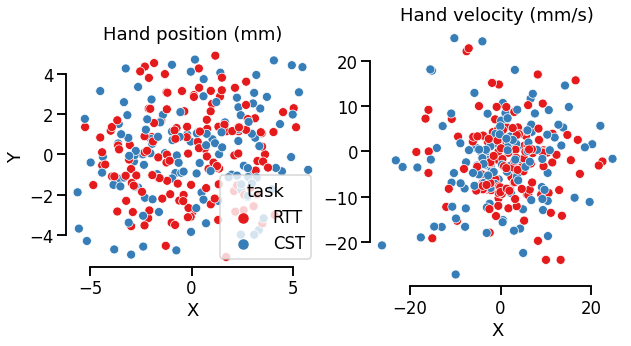

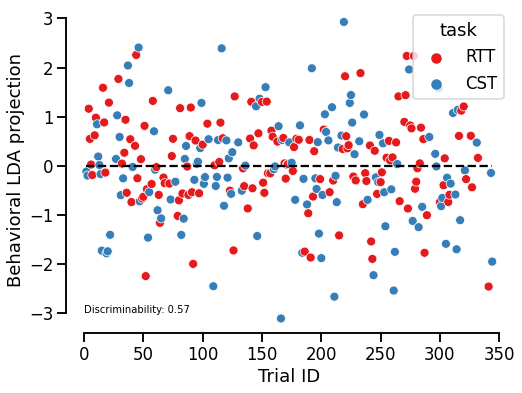

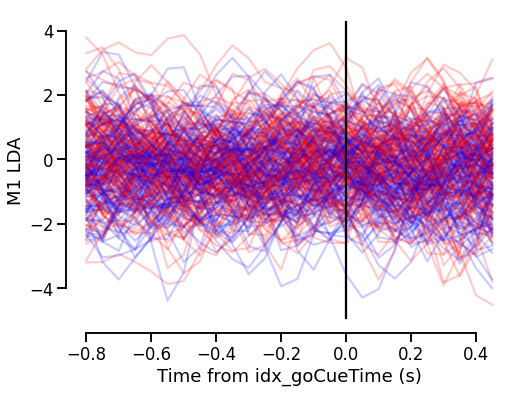

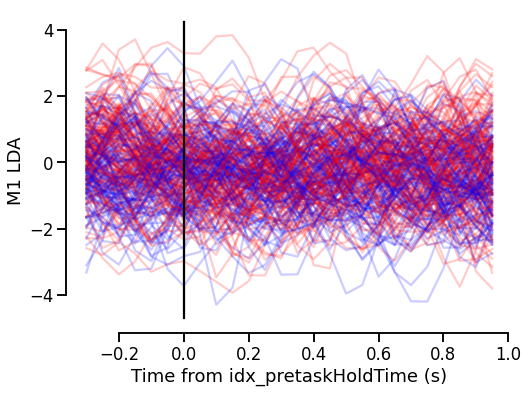

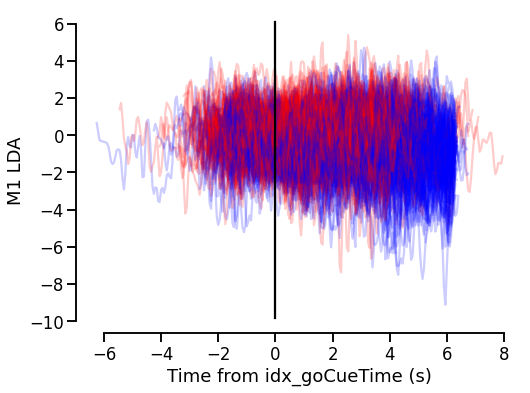

In [10]:
td_train,td_test = src.context_analysis.apply_models(td_epoch,train_epochs=['ambig_hold'],test_epochs=['hold_move','hold_move_ref_cue','full'])

fig_gen_dict = {
    'task_M1_pca':src.context_analysis.plot_hold_pca(td_train,array_name='M1',hue_order=['RTT','CST']),
    'task_M1_lda':src.context_analysis.plot_M1_lda(td_train,hue_order=['RTT','CST']),
    'task_beh':src.context_analysis.plot_hold_behavior(td_train,hue_order=['RTT','CST']),
    'task_beh_lda':src.context_analysis.plot_beh_lda(td_train,hue_order=['RTT','CST']),
    # 'task_M1_potent': src.plot_M1_hold_potent(td_train,hue_order=['RTT','CST']),
    # 'task_M1_potent_lda': src.plot_M1_potent_lda(td_train,hue_order=['RTT','CST']),
    # 'task_M1_null_lda': src.plot_M1_null_lda(td_train,hue_order=['RTT','CST']),
    # LDA traces
    'task_lda_trace':src.context_analysis.plot_M1_lda_traces(td_test.query('epoch=="hold_move"'),ref_event='idx_goCueTime',label_colors={'RTT':'r','CST':'b'}),
    'task_lda_trace_pretask':src.context_analysis.plot_M1_lda_traces(td_test.query('epoch=="hold_move_ref_cue"'),ref_event='idx_pretaskHoldTime',label_colors={'RTT':'r','CST':'b'}),
    'task_lda_trace':src.context_analysis.plot_M1_lda_traces(td_test.query('epoch=="full"'),ref_event='idx_goCueTime',label_colors={'RTT':'r','CST':'b'}),
}

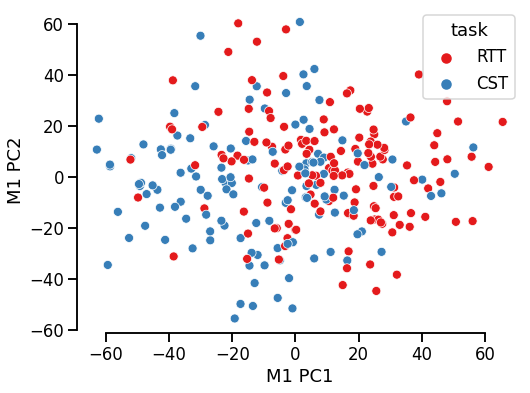

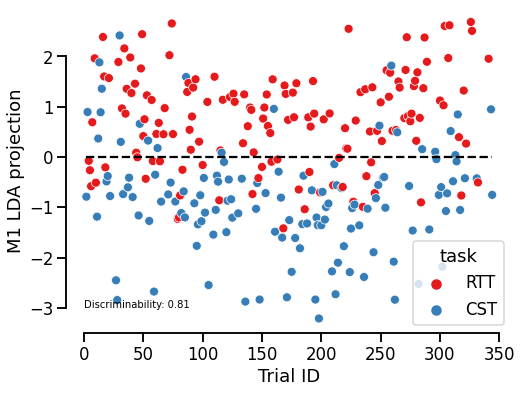

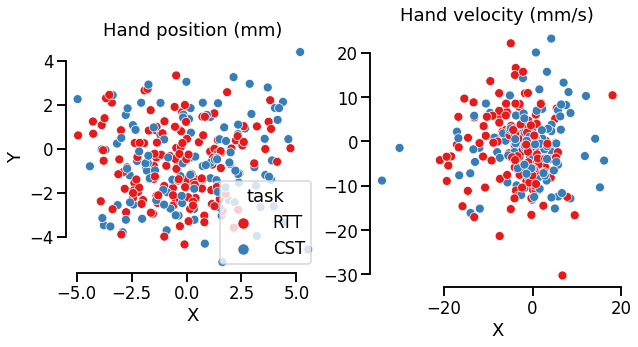

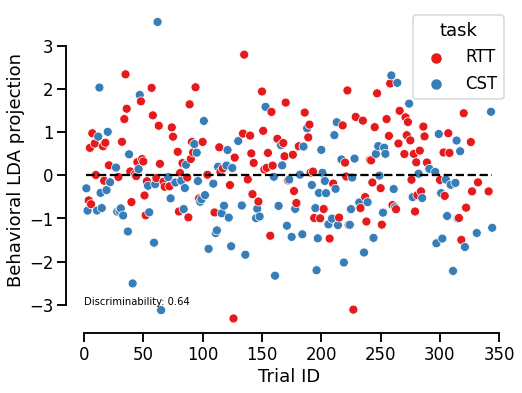

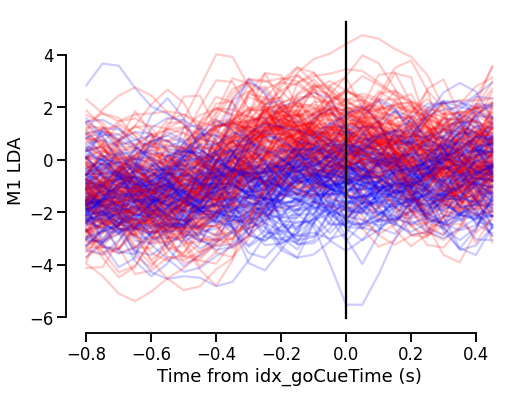

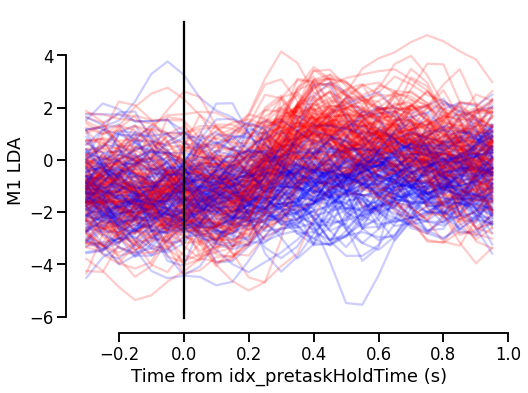

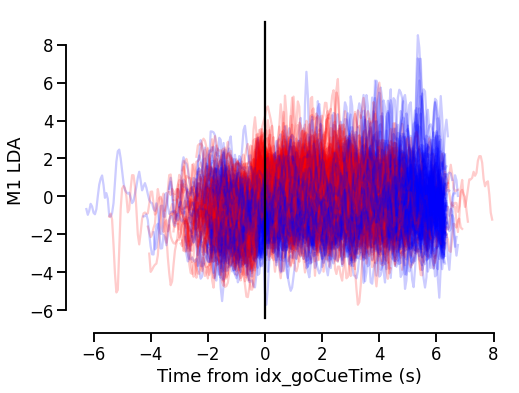

In [11]:
td_train,td_test = src.context_analysis.apply_models(td_epoch,train_epochs=['hold'],test_epochs=['hold_move','hold_move_ref_cue','full'])

fig_gen_dict = {
    'task_M1_pca':src.context_analysis.plot_hold_pca(td_train,array_name='M1',hue_order=['RTT','CST']),
    'task_M1_lda':src.context_analysis.plot_M1_lda(td_train,hue_order=['RTT','CST']),
    'task_beh':src.context_analysis.plot_hold_behavior(td_train,hue_order=['RTT','CST']),
    'task_beh_lda':src.context_analysis.plot_beh_lda(td_train,hue_order=['RTT','CST']),
    # 'task_M1_potent': src.plot_M1_hold_potent(td_train,hue_order=['RTT','CST']),
    # 'task_M1_potent_lda': src.plot_M1_potent_lda(td_train,hue_order=['RTT','CST']),
    # 'task_M1_null_lda': src.plot_M1_null_lda(td_train,hue_order=['RTT','CST']),
    # LDA traces
    'task_lda_trace':src.context_analysis.plot_M1_lda_traces(td_test.query('epoch=="hold_move"'),ref_event='idx_goCueTime',label_colors={'RTT':'r','CST':'b'}),
    'task_lda_trace_pretask':src.context_analysis.plot_M1_lda_traces(td_test.query('epoch=="hold_move_ref_cue"'),ref_event='idx_pretaskHoldTime',label_colors={'RTT':'r','CST':'b'}),
    'task_lda_trace':src.context_analysis.plot_M1_lda_traces(td_test.query('epoch=="full"'),ref_event='idx_goCueTime',label_colors={'RTT':'r','CST':'b'}),
}

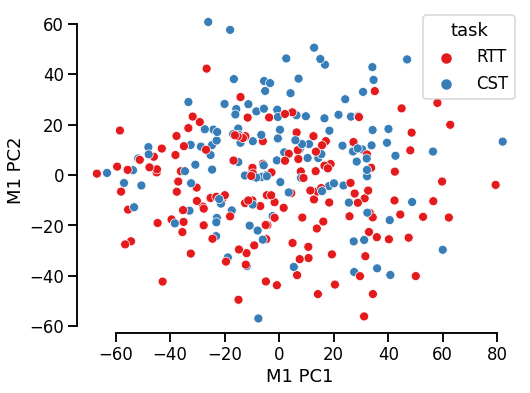

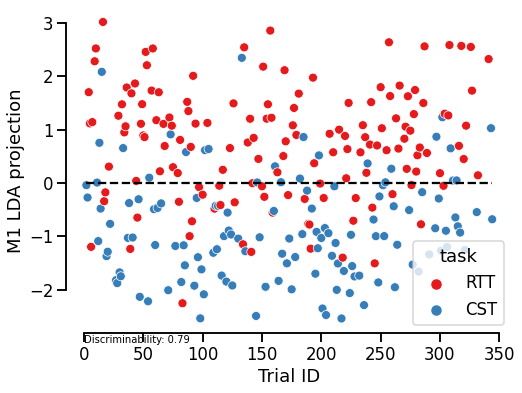

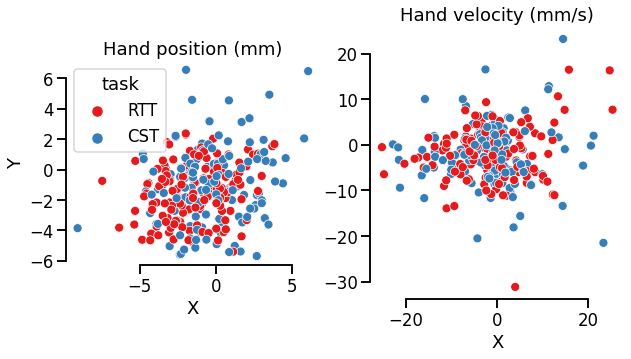

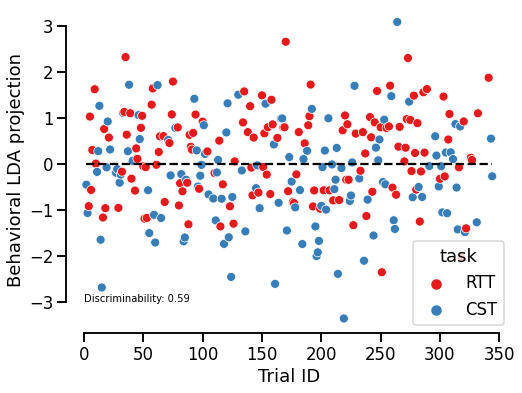

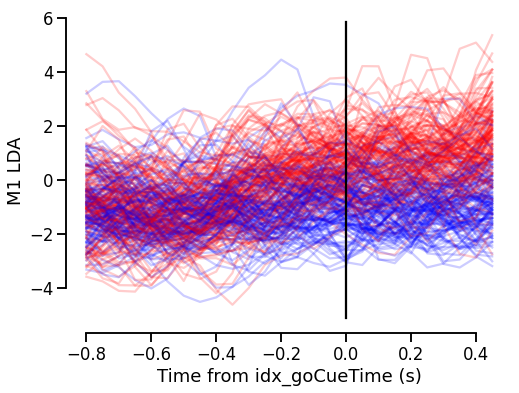

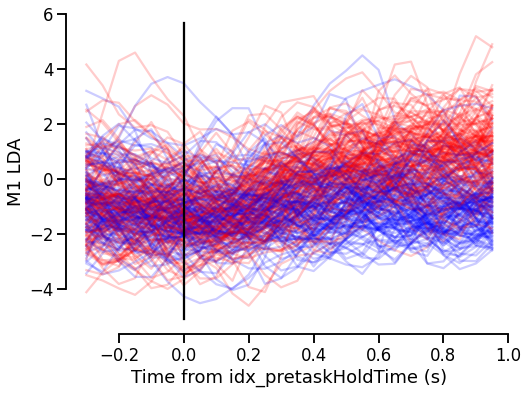

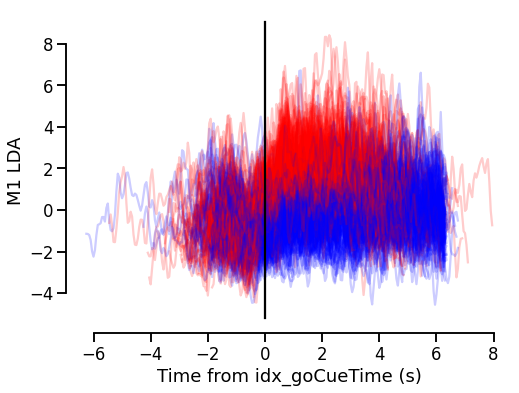

In [9]:
td_train,td_test = src.context_analysis.apply_models(td_epoch,train_epochs=['move'],test_epochs=['hold_move','hold_move_ref_cue','full'])

fig_gen_dict = {
    'task_M1_pca':src.context_analysis.plot_hold_pca(td_train,array_name='M1',hue_order=['RTT','CST']),
    'task_M1_lda':src.context_analysis.plot_M1_lda(td_train,hue_order=['RTT','CST']),
    'task_beh':src.context_analysis.plot_hold_behavior(td_train,hue_order=['RTT','CST']),
    'task_beh_lda':src.context_analysis.plot_beh_lda(td_train,hue_order=['RTT','CST']),
    # 'task_M1_potent': src.plot_M1_hold_potent(td_train,hue_order=['RTT','CST']),
    # 'task_M1_potent_lda': src.plot_M1_potent_lda(td_train,hue_order=['RTT','CST']),
    # 'task_M1_null_lda': src.plot_M1_null_lda(td_train,hue_order=['RTT','CST']),
    # LDA traces
    'task_lda_trace':src.context_analysis.plot_M1_lda_traces(td_test.query('epoch=="hold_move"'),ref_event='idx_goCueTime',label_colors={'RTT':'r','CST':'b'}),
    'task_lda_trace_pretask':src.context_analysis.plot_M1_lda_traces(td_test.query('epoch=="hold_move_ref_cue"'),ref_event='idx_pretaskHoldTime',label_colors={'RTT':'r','CST':'b'}),
    'task_lda_trace':src.context_analysis.plot_M1_lda_traces(td_test.query('epoch=="full"'),ref_event='idx_goCueTime',label_colors={'RTT':'r','CST':'b'}),
}